TokaMaker Example: Fixed boundary equilibria {#doc_tMaker_fixed_ex1}
==========
In this example we show how to compute fixed-boundary equilibria using TokaMaker for:
 1. Equilibrium in an analytic boundary shape with chosen Ip, approximate $\beta$, and flux profiles
 2. Recreation of equilibrium from an gEQDSK file, matching global quantities and profiles

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a simple internal python wrapper within OFT.

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk
from OpenFUSIONToolkit.util import mu0

## Create mesh
First we define a target size to set the resolution in our grid. This variable will be used later and represent the target edge size within our mesh, where units are in meters. In this case we are using a fairly coarse resolution of 1.5 cm (10 radial points). Note that when setting up a new machine these values will need to scale with the overall size of the device/domain. It is generally a good idea perform a convergence study, by increasing resolution (decreasing target size) by at least a factor of two in all regions, when working with a new geometry to ensure the results are not sensitive to your choice of grid size.

### Define boundary
For this example we will first generate a mesh for fixed-boundary calculation using the simple flux surface definition in \ref OpenFUSIONToolkit.TokaMaker.create_isoflux "create_isoflux". This function parameterizes a surface using a center point (R,Z), minor radius (a), and elongation and triangularity, which can can optionally have different upper and lower value. For this case we make a plasma comparable to those generated in the LTX-$\beta$ device at the Princeton Plasma Physics Laboratory.

In [3]:
mesh_dx = 0.015
LCFS_contour = create_isoflux(80,0.42,0.0,0.15,1.4,0.4)

### Define regions and attributes
We now create the mesh object and define the various logical mesh regions. In this case we only have one region, which is named `plasma` and is of type `plasma`. See other examples for more complex cases with other region types.

In [4]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('plasma',mesh_dx,'plasma')

### Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.

In [5]:
gs_mesh.add_polygon(LCFS_contour,'plasma')

### Generate mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh" method. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [6]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()

Assembling regions:
  # of unique points    = 76
  # of unique segments  = 1
Generating mesh:
  # of points  = 700
  # of cells   = 1322
  # of regions = 1


### Plot resulting regions and grid
We now plot the mesh to inspect proper generation.

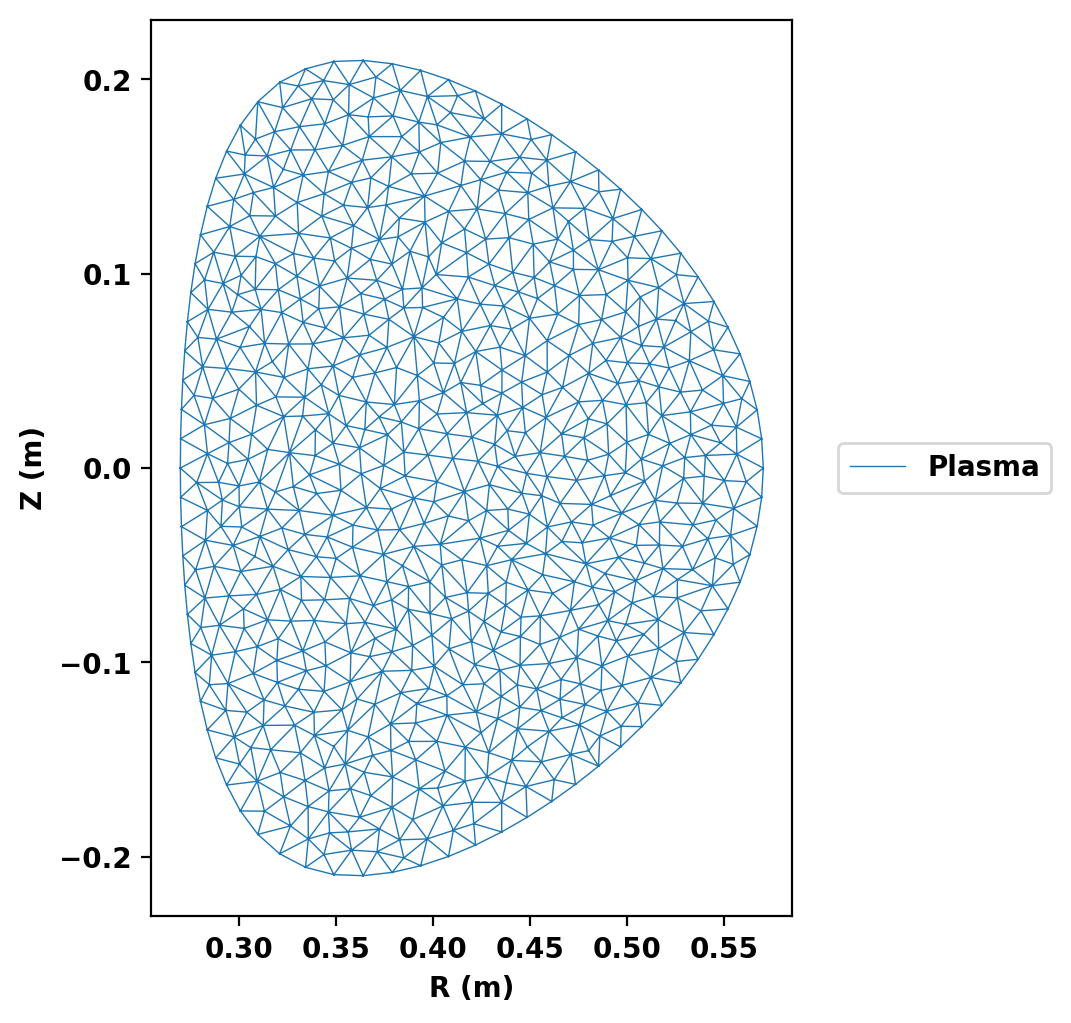

In [7]:
fig, ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

## Compute equilibria

### Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [8]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   v1_beta6
Revision id:          681e857
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_64627/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated above using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh" and set the code to operate in fixed boundary mode by setting the `free_boundary` setting to False. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [9]:
mygs.setup_mesh(mesh_pts,mesh_lc)
mygs.settings.free_boundary = False
mygs.setup(order=2,F0=0.10752)


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  9.667E-02
    # of points  =     700
    # of edges   =    2021
    # of cells   =    1322
    # of boundary points =      76
    # of boundary edges  =      76
    # of boundary cells  =      76
  Resolution statistics:
    hmin =  9.333E-03
    hrms =  1.360E-02
    hmax =  2.161E-02
  Surface grounded at vertex       1


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1



### Define global quantities and targets
For the Grad-Shafranov solve we define targets for the plasma current and the ratio the F*F' and P' contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$.

In [10]:
Ip_target = 120.E3
Beta_target = 0.5
mygs.set_targets(Ip=Ip_target,Ip_ratio=(1.0/Beta_target - 1.0))

### Initialize the flux function
Before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi". By default this calculation uses a uniform current (equal to Ip_target) over the full plasma domain. Additional options are also availble to tailor this distribution for more control.

In [11]:
err_flag = mygs.init_psi()

### Compute a fixed-boundary equilibrium
Now we can compute an equilibrium in this geometry using the default profiles for F*F' and P' by running \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve".

In [12]:
mygs.solve()

Starting non-linear GS solver
     1  4.9079E-01  1.4938E+00  3.4660E-04  4.3167E-01 -5.1820E-06  0.0000E+00
     2  5.1357E-01  1.5554E+00  1.0505E-04  4.3201E-01 -6.8745E-06  0.0000E+00
     3  5.2022E-01  1.5729E+00  3.3315E-05  4.3217E-01 -7.6919E-06  0.0000E+00
     4  5.2231E-01  1.5783E+00  1.0910E-05  4.3223E-01 -8.0980E-06  0.0000E+00
     5  5.2298E-01  1.5800E+00  3.6492E-06  4.3226E-01 -8.2974E-06  0.0000E+00
     6  5.2320E-01  1.5805E+00  1.2387E-06  4.3227E-01 -8.3937E-06  0.0000E+00
     7  5.2327E-01  1.5807E+00  4.2531E-07  4.3228E-01 -8.4396E-06  0.0000E+00
 Timing:   1.5753999992739409E-002
   Source:     7.4689999455586076E-003
   Solve:      2.6430000434629619E-003
   Boundary:   8.5599999874830246E-004
   Other:      4.7860000049695373E-003


### Print information and plot equilibrium
After computing the equilibrium, basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats" can be used.

Flux surfaces can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi" method. Additional plotting methods are also available to display other information for more complex cases. See other examples and the documentation for more information.

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.2000E+05
  Current Centroid [m]    =    0.412  0.000
  Magnetic Axis [m]       =    0.432 -0.000
  Elongation              =    1.398 (U:  1.398, L:  1.398)
  Triangularity           =    0.375 (U:  0.376, L:  0.373)
  Plasma Volume [m^3]     =    0.246
  q_0, q_95               =    0.537  1.077
  Plasma Pressure [Pa]    =   Axis:  1.0094E+04, Peak:  1.0094E+04
  Stored Energy [J]       =    1.3027E+03
  <Beta_pol> [%]          =   51.1582
  <Beta_tor> [%]          =   13.5361
  <Beta_n>   [%]          =    4.3317
  Diamagnetic flux [Wb]   =    1.4761E-03
  Toroidal flux [Wb]      =    2.8060E-02
  l_i                     =    0.7708


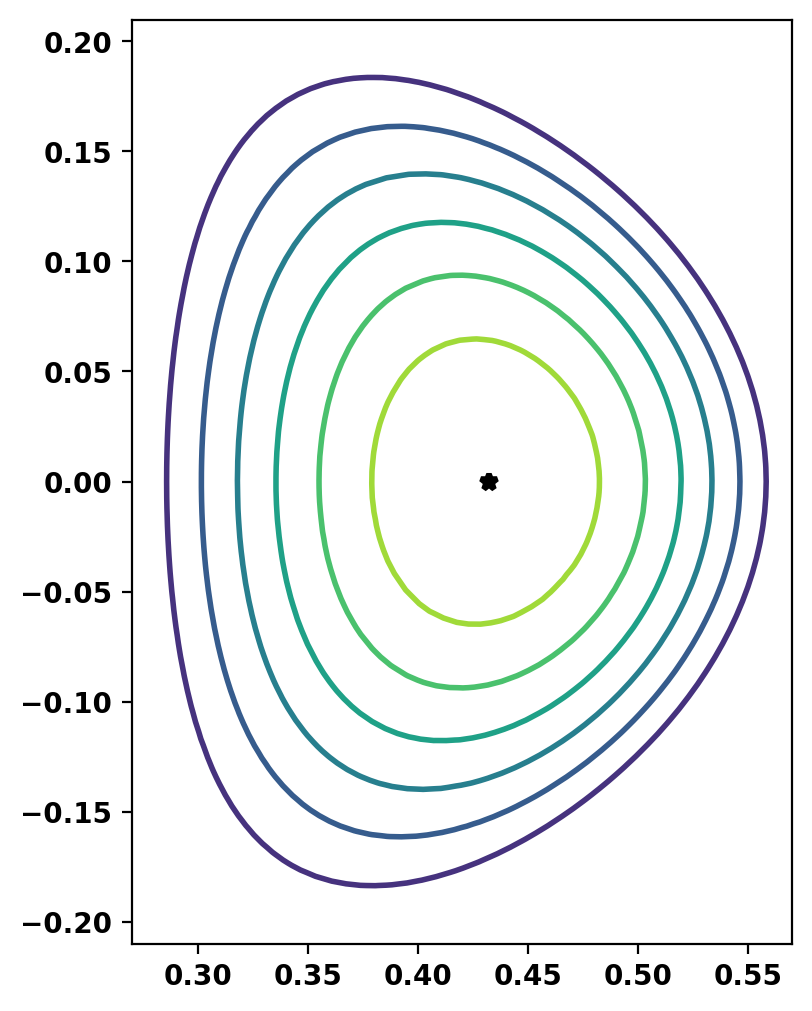

In [13]:
mygs.print_info()
# Plot flux surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_psi(fig,ax)

## Generate fixed-boundary equilibrium from gEQDSK file

### Read equilibrium from gEQDSK file
This time instead of an analytic boundary we will use the boundary from a previously computed equilibrium. To do this we load a gEQDSK file for a negative triangularity equilbirium. In EQDSK files the plasma boundary is stored in the variable `rzout`, which we set to be the LCFS_contour.

As this case is larger we also use a larger target size for the mesh

In [14]:
EQ_in = read_eqdsk('gNT_example')
LCFS_contour = EQ_in['rzout']
mesh_dx = 0.15

### Define and generate mesh
As above we now define a mesh from this boundary and generate a new computational mesh.

Assembling regions:
  # of unique points    = 67
  # of unique segments  = 1
Generating mesh:
  # of points  = 488
  # of cells   = 907
  # of regions = 1


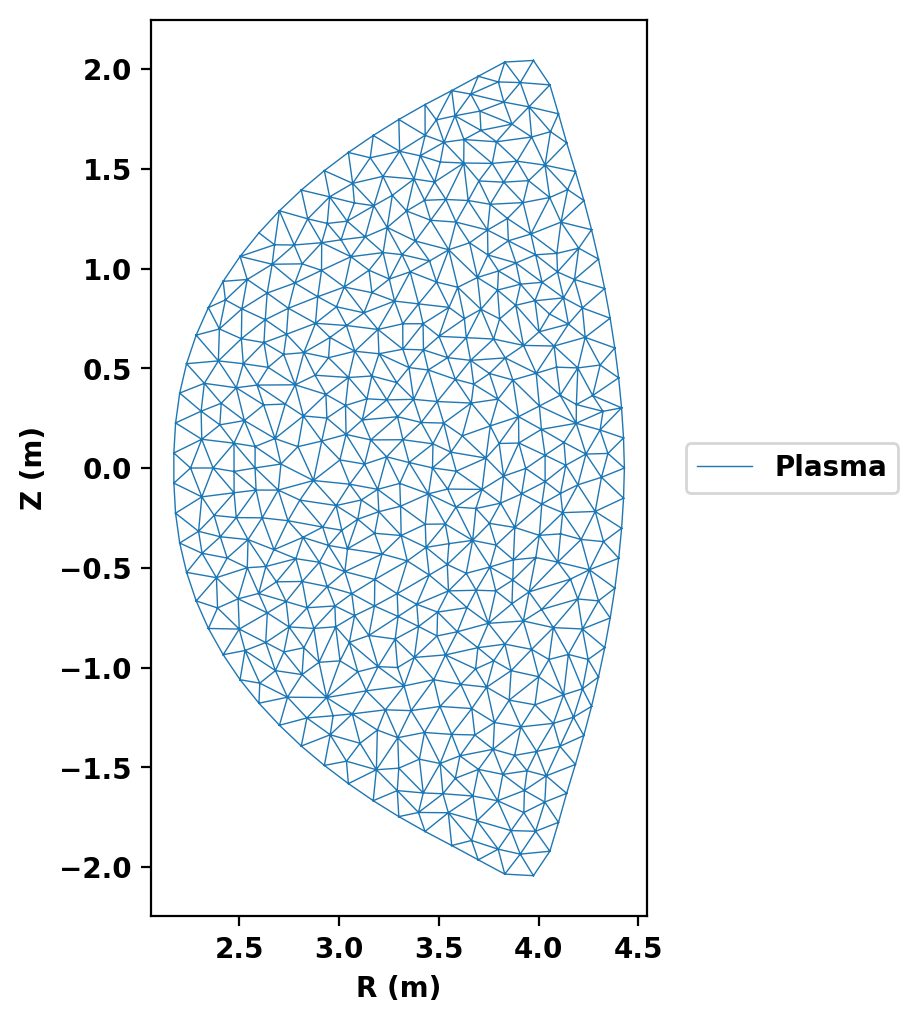

In [15]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('plasma',mesh_dx,'plasma')
# Define geometry for mesh
gs_mesh.add_polygon(LCFS_contour,'plasma')
# Generate mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
# Plot resulting mesh
fig, ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

### Update mesh in TokaMaker
To update the mesh in TokaMaker we must first call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.reset "reset" to clear the prior representation and prepare TokaMaker to accept a new configuration. Then we load in the new mesh as above using the B0 and R0 values for the input equilibrium to define F0. In this case we also increase the maximum number of solver iterations as well as the profiles use below converge somewhat slower than the defaults.

In [16]:
mygs.reset()
mygs.setup_mesh(mesh_pts,mesh_lc)
mygs.settings.free_boundary = False
mygs.settings.maxits = 60
mygs.setup(order=2,F0=EQ_in['rcentr']*EQ_in['bcentr'])


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.627E+00
    # of points  =     488
    # of edges   =    1394
    # of cells   =     907
    # of boundary points =      67
    # of boundary edges  =      67
    # of boundary cells  =      67
  Resolution statistics:
    hmin =  9.316E-02
    hrms =  1.363E-01
    hmax =  2.174E-01
  Surface grounded at vertex      34


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1



### Define global quantities and targets
Again we define a target for the plasma current, but instead of a target Ip_ratio we target a given pressure on the magnetic axis. Both values are set equal to the input equilibrium.

In [17]:
Ip_target = EQ_in['ip']
pax_target = EQ_in['pres'][0]
mygs.set_targets(Ip=Ip_target,pax=pax_target)

### Compute a fixed-boundary equilibrium
Now we can compute an equilibrium in this geometry, as above, using the default profiles for F*F' and P'. Note that as we updated the mesh we must call the flux function initialization method before this solve.

In [18]:
mygs.init_psi()
mygs.solve()

Starting non-linear GS solver
     1 -6.0903E+00  6.0973E-01  3.8521E-02  3.5785E+00  9.1950E-04  0.0000E+00
     2 -2.7057E+00  4.7616E-01  8.9093E-03  3.5758E+00  8.0435E-04  0.0000E+00
     3 -2.0621E+00  4.5264E-01  4.2214E-03  3.5687E+00  6.0357E-04  0.0000E+00
     4 -1.8881E+00  4.4648E-01  1.9706E-03  3.5645E+00  4.9471E-04  0.0000E+00
     5 -1.8327E+00  4.4457E-01  8.6951E-04  3.5625E+00  4.4383E-04  0.0000E+00
     6 -1.8131E+00  4.4392E-01  3.7096E-04  3.5616E+00  4.2136E-04  0.0000E+00
     7 -1.8057E+00  4.4367E-01  1.5555E-04  3.5613E+00  4.1171E-04  0.0000E+00
     8 -1.8028E+00  4.4358E-01  6.4620E-05  3.5611E+00  4.0760E-04  0.0000E+00
     9 -1.8017E+00  4.4354E-01  2.6703E-05  3.5610E+00  4.0584E-04  0.0000E+00
    10 -1.8012E+00  4.4352E-01  1.1001E-05  3.5610E+00  4.0508E-04  0.0000E+00
    11 -1.8010E+00  4.4352E-01  4.5235E-06  3.5610E+00  4.0475E-04  0.0000E+00
    12 -1.8009E+00  4.4351E-01  1.8578E-06  3.5610E+00  4.0461E-04  0.0000E+00
    13 -1.8009E+00  4.

### Print information and plot equilibrium

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    7.7993E+06
  Current Centroid [m]    =    3.531  0.000
  Magnetic Axis [m]       =    3.561  0.000
  Elongation              =    1.809 (U:  1.809, L:  1.810)
  Triangularity           =   -0.592 (U: -0.591, L: -0.592)
  Plasma Volume [m^3]     =   141.437
  q_0, q_95               =    2.077  4.961
  Plasma Pressure [Pa]    =   Axis:  1.4277E+06, Peak:  1.4277E+06
  Stored Energy [J]       =    1.0252E+08
  <Beta_pol> [%]          =   128.9709
  <Beta_tor> [%]          =    1.4354
  <Beta_n>   [%]          =    1.9119
  Diamagnetic flux [Wb]   =   -7.7063E-02
  Toroidal flux [Wb]      =    6.0966E+01
  l_i                     =    0.8216


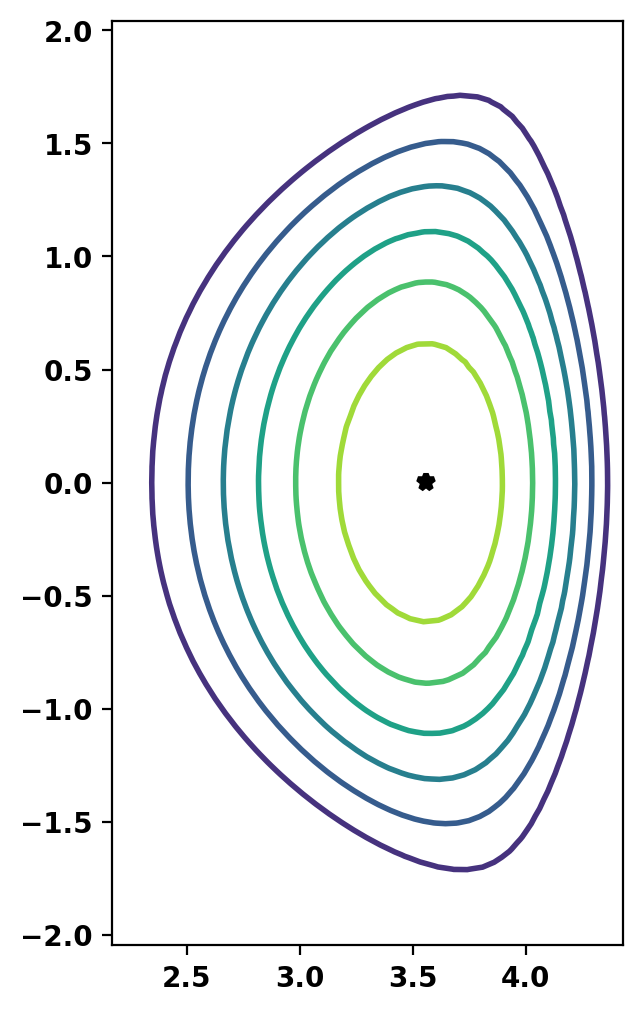

In [19]:
mygs.print_info()
fig, ax = plt.subplots(1,1)
mygs.plot_psi(fig,ax)

### Compare flux profiles
We now use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_profiles "get_profiles" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_q "get_q" to retrieve the F, F', P, P', and q profiles as a function of normalized poloidal flux. We then plot these against the corresponding profiles from the input equilibrium.

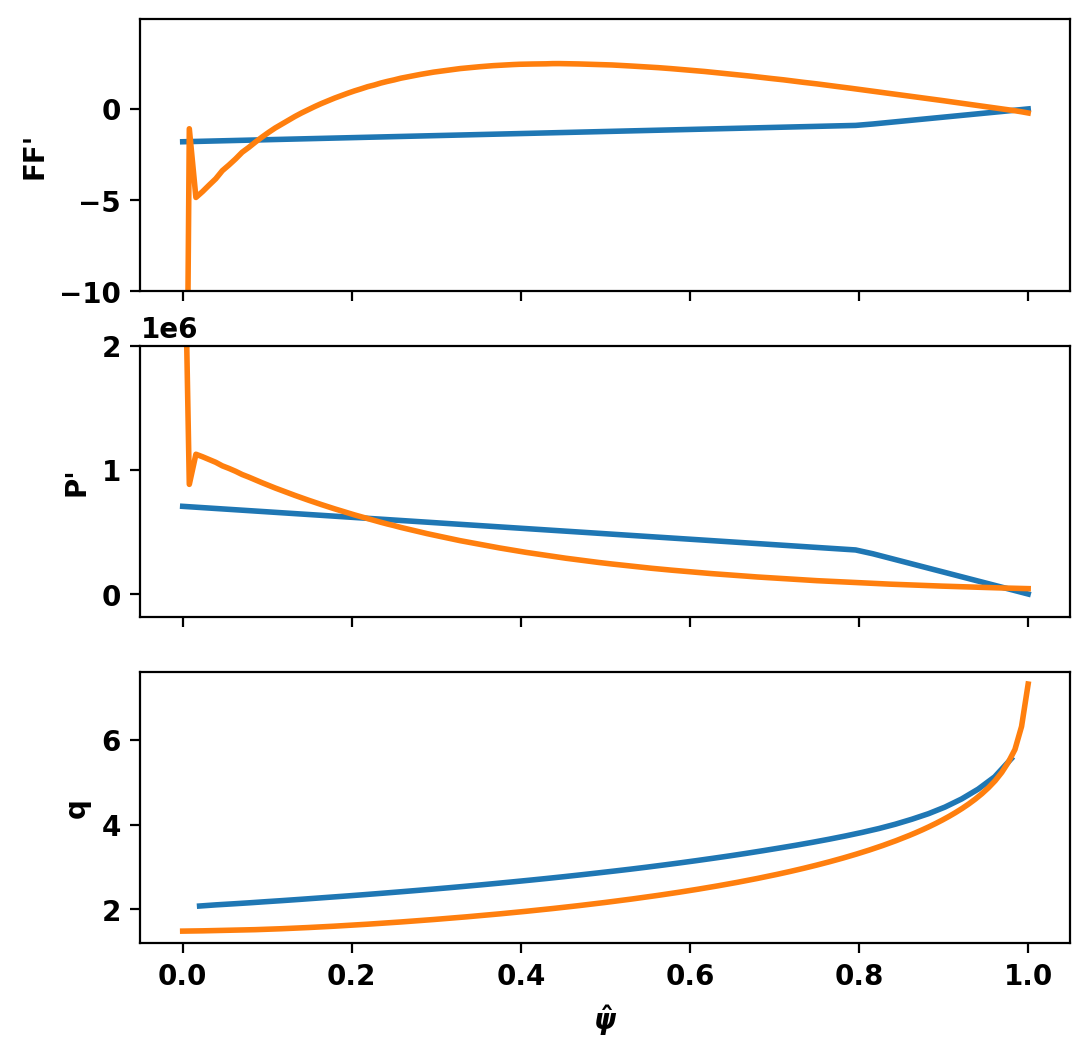

In [20]:
psi,f,fp,p,pp = mygs.get_profiles()
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q()
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,EQ_in['nr'])
# Plot F*F'
ax[0].plot(psi,f*fp)
ax[0].plot(psi_eqdsk,-EQ_in['ffprim'])
ax[0].set_ylim(bottom=-10)
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,-EQ_in['pprime'])
ax[1].set_ylim(top=2.E6)
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,EQ_in['qpsi'])
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

### Match flux profiles
The F\*F', P', and q profiles do not match the input equilibrium, so now we change the F\*F', and P' profiles to match those in the input equilibrium. To do this we will use the `linterp` profile type that defines profiles as piecewise linear functions. Additionally, we force the profiles to go to zero at the plasma boundary and clip the input profiles near the core to avoid some oscillations present in this region.

In [21]:
psi_sample = np.linspace(0.025,1.0,10) # Skip a small region at the core to clip weirdness
psi_prof = psi_sample.copy(); psi_prof[0]=0.0 # Extend profile definition to core
# Create new F*F' profile
ffp_prof = {'type': 'linterp', 'x': psi_prof, 'y': np.interp(psi_sample,psi_eqdsk,EQ_in['ffprim'])}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
ffp_prof['y'][-1] = 0.0 # Set edge to zero
# Create new P' profile
pp_prof = {'type': 'linterp', 'x': psi_prof, 'y': np.interp(psi_sample,psi_eqdsk,EQ_in['pprime'])}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)
pp_prof['y'][-1] = 0.0 # Set edge to zero
# Update profiles in TokaMaker
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Resolve equilibrium

Starting non-linear GS solver
     1  5.6477E+00  1.7697E+00  9.6820E-02  3.5615E+00  1.5868E-04  0.0000E+00
     2 -1.8545E+01  1.1764E+00  8.8806E-02  3.5140E+00 -1.7736E-04  0.0000E+00
     3 -2.4156E+00  1.5345E+00  4.8690E-02  3.5280E+00 -2.1277E-04  0.0000E+00
     4 -1.3595E+01  1.2978E+00  3.7250E-02  3.5171E+00 -2.5072E-04  0.0000E+00
     5 -5.2918E+00  1.4861E+00  2.6241E-02  3.5243E+00 -2.5657E-04  0.0000E+00
     6 -1.1458E+01  1.3516E+00  1.9528E-02  3.5192E+00 -2.4448E-04  0.0000E+00
     7 -6.8945E+00  1.4557E+00  1.4205E-02  3.5232E+00 -2.5000E-04  0.0000E+00
     8 -1.0270E+01  1.3808E+00  1.0504E-02  3.5206E+00 -2.3582E-04  0.0000E+00
     9 -7.7784E+00  1.4374E+00  7.7112E-03  3.5228E+00 -2.4049E-04  0.0000E+00
    10 -9.6174E+00  1.3963E+00  5.6915E-03  3.5213E+00 -2.3286E-04  0.0000E+00
    11 -8.2612E+00  1.4270E+00  4.1900E-03  3.5225E+00 -2.3263E-04  0.0000E+00
    12 -9.2615E+00  1.4045E+00  3.0903E-03  3.5217E+00 -2.2861E-04  0.0000E+00
    13 -8.5240E+00  1.

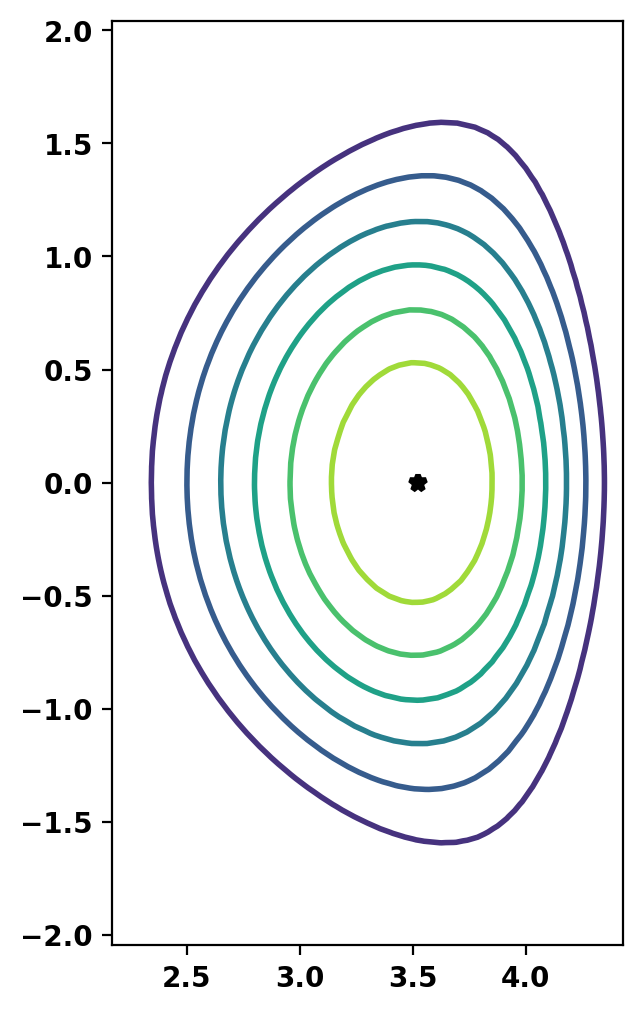

In [22]:
mygs.solve()
mygs.print_info()
fig, ax = plt.subplots(1,1)
mygs.plot_psi(fig,ax)

### Compare updated profiles
We now use compare the updated results showing that all quantities are now well matched across the entire plasma.

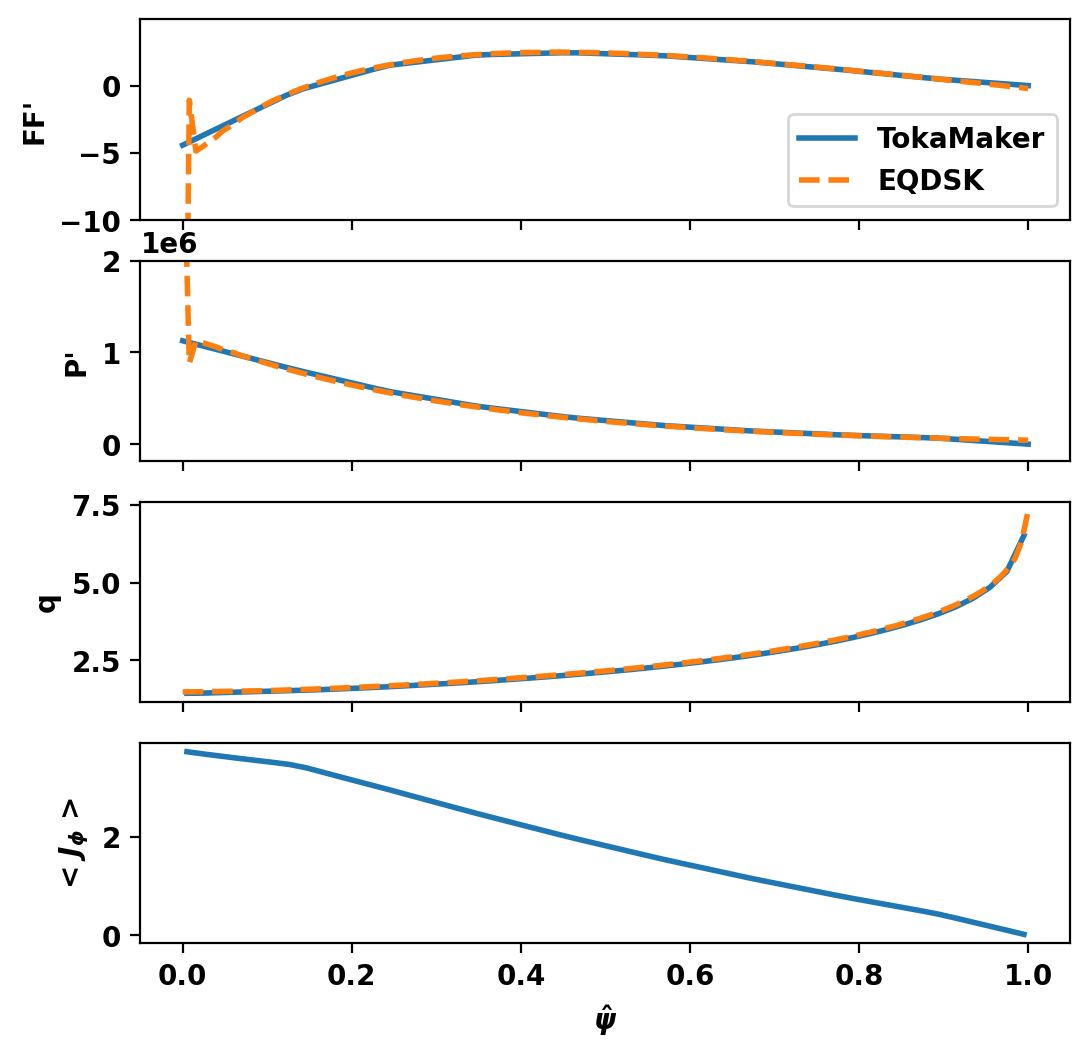

In [23]:
psi,f,fp,p,pp = mygs.get_profiles()
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.005)
fig, ax = plt.subplots(4,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,EQ_in['nr'])
psi_sample = np.linspace(0.025,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp,label='TokaMaker')
ax[0].plot(psi_eqdsk,-EQ_in['ffprim'],'--',label='EQDSK')
ax[0].set_ylim(bottom=-10)
ax[0].set_ylabel("FF'")
ax[0].legend()
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,-EQ_in['pprime'],'--')
ax[1].set_ylim(top=2.E6)
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,EQ_in['qpsi'],'--')
ax[2].set_ylabel("q")
# Plot < J_phi >
ax[3].plot(psi_q,np.interp(psi_q,psi,pp)*ravgs[0,:]*mu0+np.interp(psi_q,psi,f*fp)*ravgs[1,:])
ax[3].set_ylabel(r"< $J_{\phi}$ >")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")